In [28]:
import pandas as pd
import numpy as np
import wooldridge
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, coint
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM

In [3]:
# Load the 'intdef' dataset
df = wooldridge.data('intdef')

# Set the year as the index for plotting
df.index = pd.to_datetime(df['year'], format='%Y')

# Let's look at the two series: 3-month T-bill rate (i3) and inflation (inf)
print(df[['i3', 'inf']].head())

              i3  inf
year                 
1948-01-01  1.04  8.1
1949-01-01  1.10 -1.2
1950-01-01  1.22  1.3
1951-01-01  1.55  7.9
1952-01-01  1.77  1.9


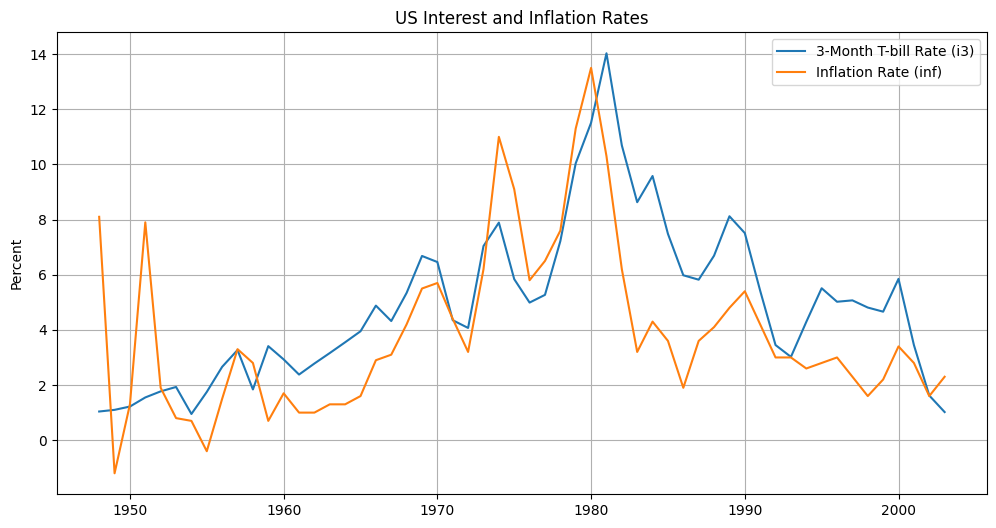

In [4]:
# Plot the series to visualize them
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['i3'], label='3-Month T-bill Rate (i3)')
plt.plot(df.index, df['inf'], label='Inflation Rate (inf)')
plt.title('US Interest and Inflation Rates')
plt.ylabel('Percent')
plt.legend()
plt.grid(True)
plt.show()

### Engle-Granger two-step method 

In [5]:
## Step 1: Test for Unit Roots in Individual Series
# Perform ADF test on i3
adf_i3 = adfuller(df['i3'])
print(f'ADF Test for i3 (Interest Rate):')
print(f'  Test Statistic: {adf_i3[0]:.4f}')
print(f'  p-value: {adf_i3[1]:.4f}') # High p-value -> Fail to reject H0

# Perform ADF test on inf
adf_inf = adfuller(df['inf'])
print(f'\nADF Test for inf (Inflation):')
print(f'  Test Statistic: {adf_inf[0]:.4f}')
print(f'  p-value: {adf_inf[1]:.4f}') # High p-value -> Fail to reject H0

ADF Test for i3 (Interest Rate):
  Test Statistic: -1.7794
  p-value: 0.3907

ADF Test for inf (Inflation):
  Test Statistic: -1.7459
  p-value: 0.4077


In [6]:
## Step 2: Test for Cointegration

# Perform the Engle-Granger Cointegration Test
# We test if i3 and inf are cointegrated
coint_test_result = coint(df['i3'], df['inf'])

print('Engle-Granger Cointegration Test Results:')
print(f'  Test Statistic: {coint_test_result[0]:.4f}')
print(f'  p-value: {coint_test_result[1]:.4f}')
print('  Critical Values:')
print(f'    1%: {coint_test_result[2][0]:.4f}')
print(f'    5%: {coint_test_result[2][1]:.4f}')
print(f'   10%: {coint_test_result[2][2]:.4f}')

Engle-Granger Cointegration Test Results:
  Test Statistic: -4.0503
  p-value: 0.0061
  Critical Values:
    1%: -4.1066
    5%: -3.4495
   10%: -3.1225


Estimated Equilibrium Error (First 5 values):
year
1948-01-01   -6.568867
1949-01-01   -0.551646
1950-01-01   -2.033049
1951-01-01   -5.930755
1952-01-01   -1.867386
dtype: float64


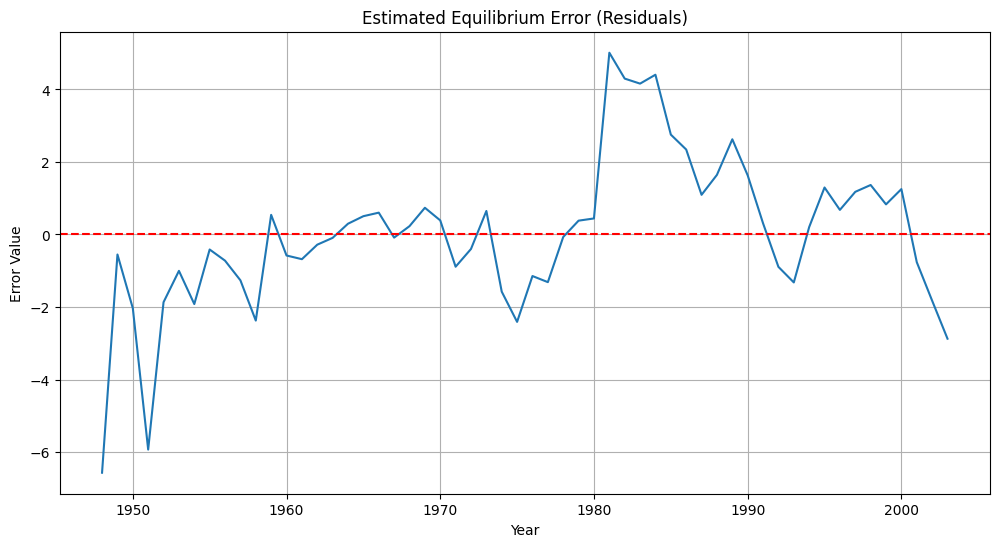

In [7]:
## Step 3: Equilibrium error

# Define dependent (y) and independent (x) variables
y = df['i3']
X = df['inf']

# Add a constant (intercept) to the regression model
X = sm.add_constant(X)

# 1. Estimate the long-run relationship with OLS
long_run_model = sm.OLS(y, X).fit()

# 2. Extract the residuals, which are the equilibrium error
equilibrium_error = long_run_model.resid

# Display the first few values of the equilibrium error
print("Estimated Equilibrium Error (First 5 values):")
print(equilibrium_error.head())

# Plot the equilibrium error
plt.figure(figsize=(12, 6))
plt.plot(equilibrium_error.index, equilibrium_error)
plt.axhline(0, color='red', linestyle='--') # Add a line at zero
plt.title('Estimated Equilibrium Error (Residuals)')
plt.ylabel('Error Value')
plt.xlabel('Year')
plt.grid(True)
plt.show()

In [8]:
#  Common trends: Stock and Watson (1988).

# Define our variables
# Y is the dependent variable (i3)
# X is the independent variable (inf), with a constant added
Y = df['i3']
X = sm.add_constant(df['inf'])

# Run the OLS regression to find the cointegrating parameters
model = sm.OLS(Y, X).fit()

# Print the regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     i3   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     46.19
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           8.81e-09
Time:                        10:01:56   Log-Likelihood:                -120.66
No. Observations:                  56   AIC:                             245.3
Df Residuals:                      54   BIC:                             249.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4203      0.463      5.224      0.0

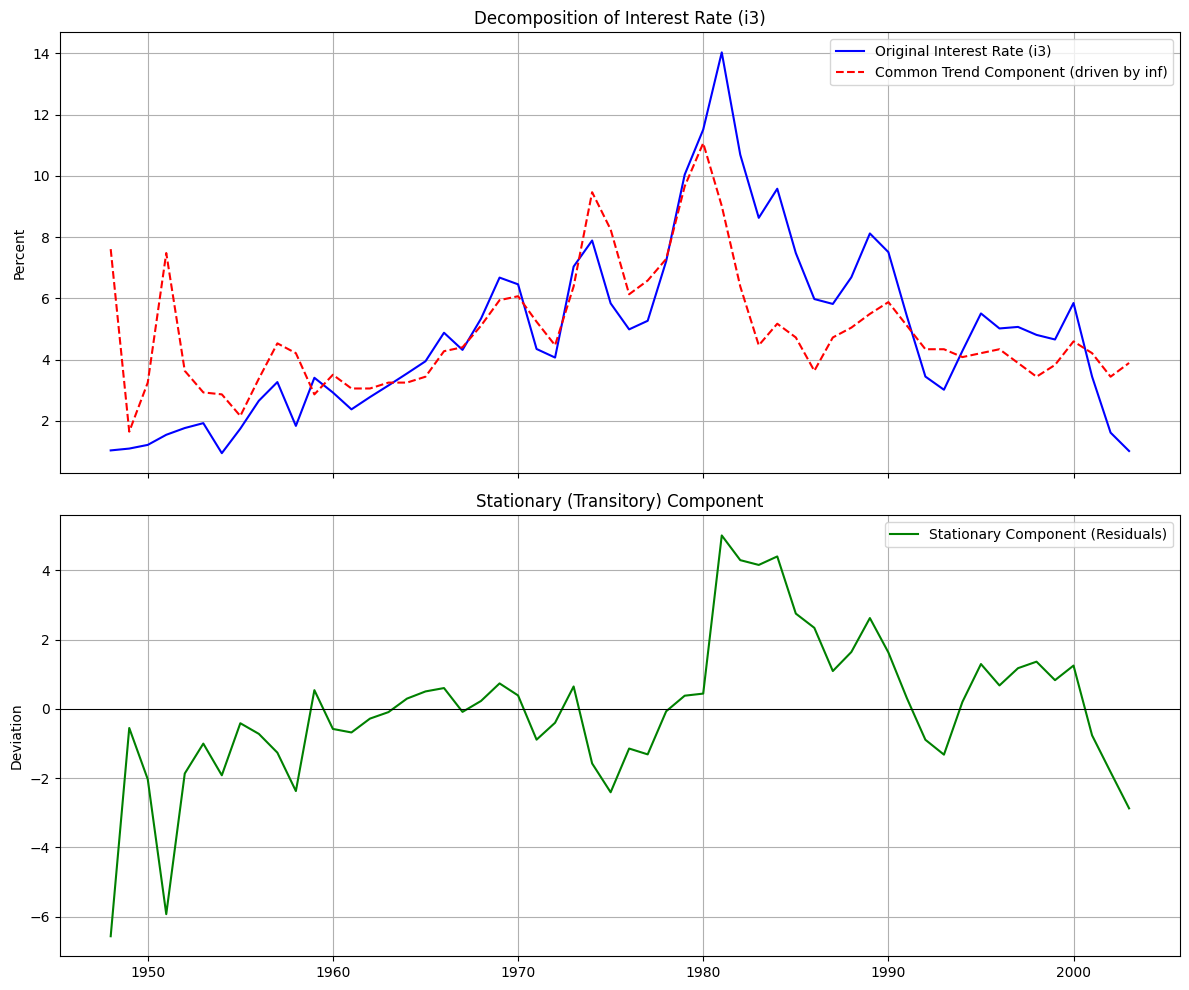

ADF test p-value on residuals: 0.0013


In [9]:
# Add the components to our DataFrame
df['common_component'] = model.fittedvalues
df['stationary_component'] = model.resid

# Create the plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# --- Top Plot: Original Series vs. Common Component ---
ax1.plot(df.index, df['i3'], label='Original Interest Rate (i3)', color='blue')
ax1.plot(df.index, df['common_component'], label='Common Trend Component (driven by inf)', linestyle='--', color='red')
ax1.set_title('Decomposition of Interest Rate (i3)')
ax1.set_ylabel('Percent')
ax1.legend()
ax1.grid(True)

# --- Bottom Plot: Stationary Component ---
ax2.plot(df.index, df['stationary_component'], label='Stationary Component (Residuals)', color='green')
ax2.axhline(0, color='black', linestyle='-', linewidth=0.75)
ax2.set_title('Stationary (Transitory) Component')
ax2.set_ylabel('Deviation')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# We can also formally test the stationary component (residuals) again
adf_residuals = adfuller(df['stationary_component'])
print(f'ADF test p-value on residuals: {adf_residuals[1]:.4f}')

### The Two-Step ECM Approach

In [10]:
## Step 1: Estimating the Error Correction Term

# Load data
df = wooldridge.data('intdef')
df.index = pd.to_datetime(df['year'], format='%Y')

# Step 1: Run the long-run OLS regression (i3 on inf)
Y_long_run = df['i3']
X_long_run = sm.add_constant(df['inf'])
model_long_run = sm.OLS(Y_long_run, X_long_run).fit()

# Get the residuals (the "errors") and create the lagged error correction term
df['error_term'] = model_long_run.resid
df['ec_term_lagged'] = df['error_term'].shift(1)

print("First few values of the error and lagged error term:")
print(df[['i3', 'inf', 'error_term', 'ec_term_lagged']].head())

First few values of the error and lagged error term:
              i3  inf  error_term  ec_term_lagged
year                                             
1948-01-01  1.04  8.1   -6.568867             NaN
1949-01-01  1.10 -1.2   -0.551646       -6.568867
1950-01-01  1.22  1.3   -2.033049       -0.551646
1951-01-01  1.55  7.9   -5.930755       -2.033049
1952-01-01  1.77  1.9   -1.867386       -5.930755


In [11]:
## Step 2: Estimating the Error Correction Model (for Δi3)

# Create the differenced (change) variables
df['delta_i3'] = df['i3'].diff()
df['delta_inf'] = df['inf'].diff()

# Create lagged differenced variables for the model
df['delta_i3_lagged'] = df['delta_i3'].shift(1)
df['delta_inf_lagged'] = df['delta_inf'].shift(1)

# Drop NaN values created by differencing and lagging
ecm_df = df.dropna()

# Define variables for the ECM regression
Y_ecm = ecm_df['delta_i3']
X_ecm = ecm_df[['ec_term_lagged', 'delta_i3_lagged', 'delta_inf_lagged']]
X_ecm = sm.add_constant(X_ecm) # Add an intercept

# Estimate the Error Correction Model
model_ecm = sm.OLS(Y_ecm, X_ecm).fit()
print(model_ecm.summary())

                            OLS Regression Results                            
Dep. Variable:               delta_i3   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     2.982
Date:                Thu, 31 Jul 2025   Prob (F-statistic):             0.0400
Time:                        10:01:56   Log-Likelihood:                -89.079
No. Observations:                  54   AIC:                             186.2
Df Residuals:                      50   BIC:                             194.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0352      0.179  

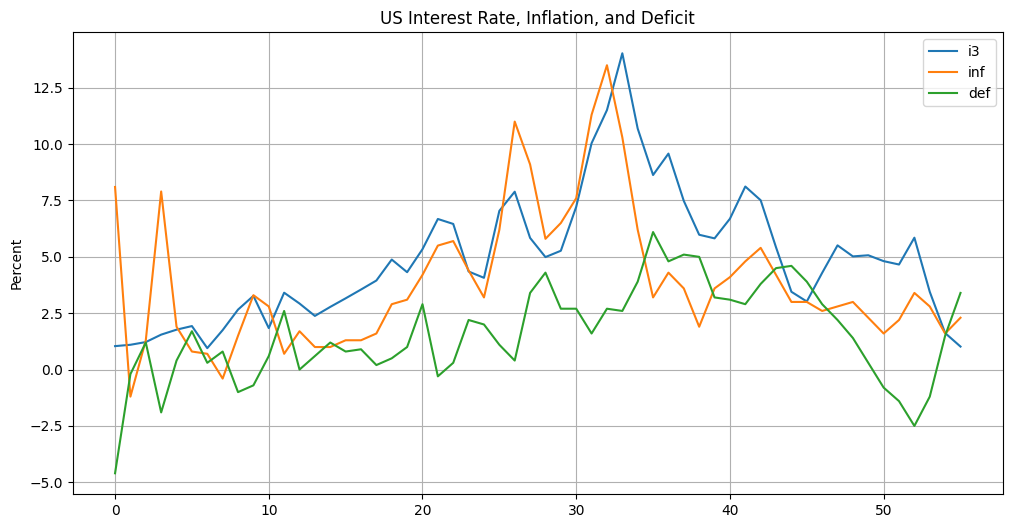

Augmented Dickey-Fuller Test Results:
  i3: p-value = 0.3907
  inf: p-value = 0.4077
  def: p-value = 0.0032


In [12]:
# ECM for the n-variable case

# Load the 'intdef' dataset
df = wooldridge.data('intdef')

# Select the variables of interest
data = df[['i3', 'inf', 'def']]

# Plot the series to visualize them
data.plot(figsize=(12, 6), title='US Interest Rate, Inflation, and Deficit')
plt.ylabel('Percent')
plt.grid(True)
plt.show()

# Prerequisite: Confirm the series are I(1) using the ADF test
print("Augmented Dickey-Fuller Test Results:")
for name, series in data.items():
    result = adfuller(series)
    print(f'  {name}: p-value = {result[1]:.4f}') # We expect high p-values

In [13]:
# Perform the Johansen test
# det_order = 1 allows for a constant in the cointegrating relationship.
# k_ar_diff = 1 specifies 1 lag in the VECM, corresponding to a VAR(2) model.
johansen_result = coint_johansen(data, det_order=1, k_ar_diff=1)

# Extract and print the trace statistic results
trace_stats = johansen_result.lr1
crit_vals = johansen_result.cvt

print("Johansen Cointegration Trace Test Results")
print("="*50)
print("H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)")
print("-"*50)
for i, r in enumerate([0, 1, 2]):
    decision = "Reject H0" if trace_stats[i] > crit_vals[i, 1] else "Fail to Reject H0"
    print(f"r <= {r:<10} {trace_stats[i]:<14.3f} {crit_vals[i, 1]:<15.3f} {decision}")
print("="*50)

Johansen Cointegration Trace Test Results
H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)
--------------------------------------------------
r <= 0          53.048         35.012          Reject H0
r <= 1          18.378         18.398          Fail to Reject H0
r <= 2          4.611          3.841           Reject H0


### The Engle-Granger Methodology

In [14]:
## Step 1: Pretest Variables for Order of Integration

# Load and prepare the data
df = wooldridge.data('intdef')

# Perform ADF test on the level of each series
print("--- Step 1: ADF Test on Levels ---")
adf_i3 = adfuller(df['i3'])
print(f'ADF p-value for i3 (Interest Rate): {adf_i3[1]:.4f}')

adf_inf = adfuller(df['inf'])
print(f'ADF p-value for inf (Inflation): {adf_inf[1]:.4f}')

--- Step 1: ADF Test on Levels ---
ADF p-value for i3 (Interest Rate): 0.3907
ADF p-value for inf (Inflation): 0.4077


In [15]:
## Step 2: Estimate the Long-Run Relationship

# Define dependent (Y) and independent (X) variables
Y = df['i3']
X = sm.add_constant(df['inf'])

# Run the OLS regression
model_long_run = sm.OLS(Y, X).fit()

print("\n--- Step 2: Long-Run OLS Regression ---")
print("Estimated Coefficients:")
print(model_long_run.summary())


--- Step 2: Long-Run OLS Regression ---
Estimated Coefficients:
                            OLS Regression Results                            
Dep. Variable:                     i3   R-squared:                       0.461
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     46.19
Date:                Thu, 31 Jul 2025   Prob (F-statistic):           8.81e-09
Time:                        10:01:56   Log-Likelihood:                -120.66
No. Observations:                  56   AIC:                             245.3
Df Residuals:                      54   BIC:                             249.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [16]:
## Step 3: Test Residuals for Stationarity (The Cointegration Test)

# The coint() function runs the long-run regression and tests the residuals
coint_test_result = coint(df['i3'], df['inf'])

print("\n--- Step 3: Cointegration Test on Residuals ---")
print(f'Test Statistic: {coint_test_result[0]:.4f}')
print(f'P-value: {coint_test_result[1]:.4f}')
print(f'5% Critical Value: {coint_test_result[2][1]:.4f}')


--- Step 3: Cointegration Test on Residuals ---
Test Statistic: -4.0503
P-value: 0.0061
5% Critical Value: -3.4495


--- Verifying Orders of Integration ---
p-value for 1st Diff of 'inf': 0.000 -> I(1)
p-value for 1st Diff of 'i3': 0.000 -> I(1)

p-value for 1st Diff of 'lp': 0.362
p-value for 2nd Diff of 'lp': 0.000 -> I(2)


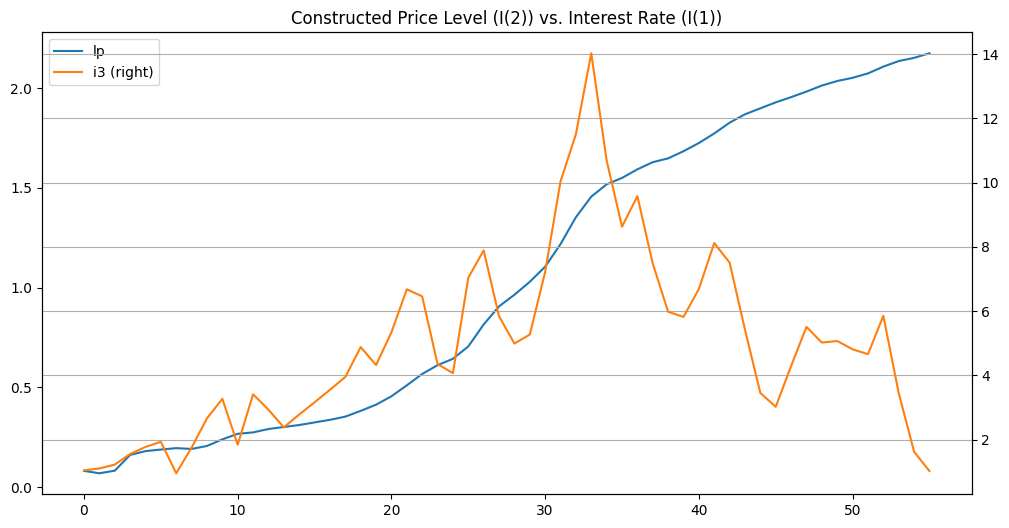

In [17]:
## With I(2) variables

# Load the data
df = wooldridge.data('intdef')

# --- Verify that inf and i3 are I(1) ---
print("--- Verifying Orders of Integration ---")
p_inf = adfuller(df['inf'].diff().dropna())[1]
p_i3 = adfuller(df['i3'].diff().dropna())[1]
print(f"p-value for 1st Diff of 'inf': {p_inf:.3f} -> I(1)")
print(f"p-value for 1st Diff of 'i3': {p_i3:.3f} -> I(1)\n")

# --- Construct and verify the I(2) log price level ---
# We create the price level by accumulating the inflation rate
df['lp'] = (df['inf'] / 100).cumsum()

p_lp_diff1 = adfuller(df['lp'].diff().dropna())[1]
p_lp_diff2 = adfuller(df['lp'].diff().diff().dropna())[1]
print(f"p-value for 1st Diff of 'lp': {p_lp_diff1:.3f}")
print(f"p-value for 2nd Diff of 'lp': {p_lp_diff2:.3f} -> I(2)")

# Plot the series
df[['lp', 'i3']].plot(figsize=(12, 6), secondary_y='i3',
                      title='Constructed Price Level (I(2)) vs. Interest Rate (I(1))')
plt.grid(True)
plt.show()

In [18]:
### Step A: The Multicointegration Regression
Y = df['lp']
X = sm.add_constant(df['i3'])
model = sm.OLS(Y, X).fit()
print(model.summary())
residuals = model.resid

print("\n--- Step A: Multicointegration Regression Summary ---")
print(f"R-squared: {model.rsquared:.3f}")

### Step B: Testing the Residuals
adf_residuals = adfuller(residuals)

print("\n--- Step B: ADF Test on Residuals ---")
print(f'ADF Test Statistic: {adf_residuals[0]:.4f}')
print(f'p-value: {adf_residuals[1]:.4f}')

                            OLS Regression Results                            
Dep. Variable:                     lp   R-squared:                       0.167
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     10.85
Date:                Thu, 31 Jul 2025   Prob (F-statistic):            0.00175
Time:                        10:01:56   Log-Likelihood:                -57.768
No. Observations:                  56   AIC:                             119.5
Df Residuals:                      54   BIC:                             123.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5194      0.184      2.818      0.0

### Hyphotesis testing within the Johansen methodology

In [ ]:
## 1. Preliminary Step: Determine the Cointegrating Rank

# Load the 'hseinv' dataset
hseinv = wooldridge.data('hseinv')

# Select the correct variables of interest from your list
data = hseinv[['linv', 'lprice', 'lpop']]

# Run the Johansen test to find the rank (r)
johansen_result = coint_johansen(data, det_order=1, k_ar_diff=1)
trace_stats = johansen_result.lr1
crit_vals = johansen_result.cvt

print("Johansen Cointegration Trace Test Results")
print("="*60)
print("H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)")
print("-"*60)
for i, r in enumerate([0, 1, 2]):
    decision = "Reject H0" if trace_stats[i] > crit_vals[i, 1] else "Fail to Reject H0"
    print(f"r <= {r:<10} {trace_stats[i]:<14.3f} {crit_vals[i, 1]:<15.3f} {decision}")
print("="*60)

Johansen Cointegration Trace Test Results
H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)
------------------------------------------------------------
r <= 0          35.359         35.012          Reject H0
r <= 1          6.912          18.398          Fail to Reject H0
r <= 2          2.588          3.841           Fail to Reject H0


In [20]:
## 2. Hypothesis Test on the Cointegrating Vector

# Estimate the VECM with cointegrating rank = 1
model = VECM(data, k_ar_diff=1, coint_rank=1, deterministic='ci')
vecm_results = model.fit()

# Print the full summary
print(vecm_results.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation linv
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.linv        0.3585      0.131      2.727      0.006       0.101       0.616
L1.lprice     -3.1677      0.963     -3.290      0.001      -5.055      -1.281
L1.lpop        1.0916      1.359      0.803      0.422      -1.573       3.756
Det. terms outside the coint. relation & lagged endog. parameters for equation lprice
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.linv        0.0204      0.021      0.968      0.333      -0.021       0.062
L1.lprice     -0.1074      0.155     -0.694      0.487      -0.411       0.196
L1.lpop        0.2973      0.218      1.361      0.173      -0.131       0.725
Det. terms outside the coint. relation &

In [21]:
## Finding the Optimal Lag Length

# Create a VAR model object
model = VAR(data)

# Select the optimal lag order based on AIC and BIC
# Note: select_order can do this automatically, but a loop is illustrative.
lag_selection_results = model.select_order(maxlags=8)

print(lag_selection_results.summary())

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -14.83      -14.70   3.613e-07      -14.79
1      -25.63      -25.09   7.430e-12      -25.45
2      -26.10     -25.16*   4.704e-12      -25.78
3      -26.11      -24.76   4.850e-12      -25.65
4      -25.91      -24.16   6.306e-12      -25.32
5      -25.62      -23.46   9.527e-12      -24.88
6      -26.71      -24.15  3.874e-12*     -25.84*
7      -26.77      -23.81   4.946e-12      -25.76
8     -26.88*      -23.52   7.210e-12      -25.74
-------------------------------------------------


### To Difference or Not to Difference

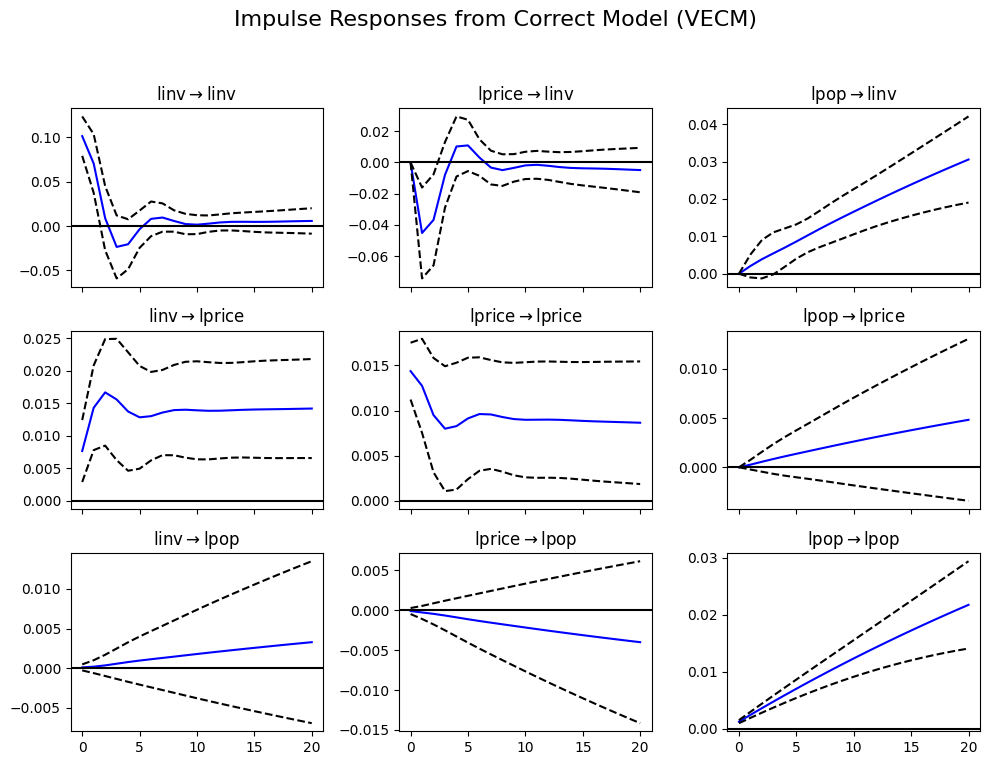

In [22]:
# Estimate the correct model: a VECM
model_vecm = VECM(data, k_ar_diff=1, coint_rank=1, deterministic='ci')
vecm_results = model_vecm.fit()

# Calculate and plot the impulse responses
# orth=True computes orthogonalized IRFs to account for contemporaneous correlation.
irf_vecm = vecm_results.irf(periods=20)
fig_vecm = irf_vecm.plot(orth=True, figsize=(10, 8))
fig_vecm.suptitle('Impulse Responses from Correct Model (VECM)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

C:\Users\daves\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


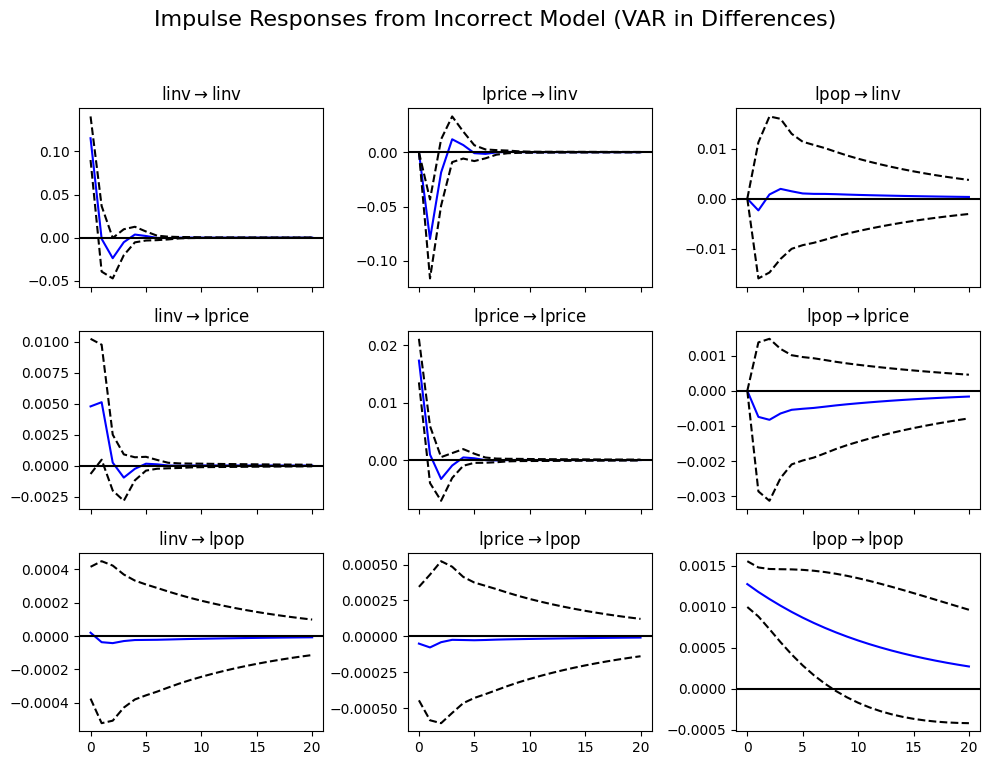

In [23]:
## The Incorrect Model: VAR in First Differences

# Create the misspecified model: VAR on first-differenced data
data_diff = data.diff().dropna()
model_var = VAR(data_diff)
# CORRECTED LINE: The lag order is a positional argument.
var_results = model_var.fit(1)

# Calculate and plot the impulse responses
irf_var = var_results.irf(periods=20)
fig_var = irf_var.plot(orth=True, figsize=(10, 8))
fig_var.suptitle('Impulse Responses from Incorrect Model (VAR in Differences)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### The Johansen Methodology

In [35]:
## Step 1: Pre-testing and Model Setup

# Load the 'hseinv' dataset
hseinv = wooldridge.data('hseinv')

# Select the correct variables of interest from your list
data = hseinv[['linv', 'lprice', 'lpop']]

# 1a: Confirm variables are I(1) using the ADF test
print("--- ADF Test Results (Levels) ---")
for name, series in data.items():
    result = adfuller(series)
    print(f'  {name}: p-value = {result[1]:.4f}')
print("Conclusion: All series appear to be I(1).\n")


# 1b: Select the optimal lag length
print("--- Lag Length Selection ---")
model_var = VAR(data)
lag_selection_results = model_var.select_order(maxlags=8)
print(lag_selection_results.summary())

# Store the optimal lag order from AIC
p = lag_selection_results.aic
print(f"\nOptimal lag order (p) based on AIC is: {p}")

--- ADF Test Results (Levels) ---
  linv: p-value = 0.4313
  lprice: p-value = 0.8111
  lpop: p-value = 0.4538
Conclusion: All series appear to be I(1).

--- Lag Length Selection ---
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -14.83      -14.70   3.613e-07      -14.79
1      -25.63      -25.09   7.430e-12      -25.45
2      -26.10     -25.16*   4.704e-12      -25.78
3      -26.11      -24.76   4.850e-12      -25.65
4      -25.91      -24.16   6.306e-12      -25.32
5      -25.62      -23.46   9.527e-12      -24.88
6      -26.71      -24.15  3.874e-12*     -25.84*
7      -26.77      -23.81   4.946e-12      -25.76
8     -26.88*      -23.52   7.210e-12      -25.74
-------------------------------------------------

Optimal lag order (p) based on AIC is: 8


In [36]:
## Step 2: Determining the Cointegrating Rank (r)

# Perform the Johansen test
# We use p-1 = 1 lagged difference term.
johansen_result = coint_johansen(data, det_order=1, k_ar_diff=7)

# Print the trace statistic results
print("\n--- Step 2: Johansen Cointegration Trace Test ---")
trace_stats = johansen_result.lr1
crit_vals = johansen_result.cvt
print("H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)")
for i, r in enumerate([0, 1, 2]):
    decision = "Reject H0" if trace_stats[i] > crit_vals[i, 1] else "Fail to Reject H0"
    print(f"r <= {r:<10} {trace_stats[i]:<14.3f} {crit_vals[i, 1]:<15.3f} {decision}")


--- Step 2: Johansen Cointegration Trace Test ---
H0: Rank <= r   Trace Stat.   5% Crit. Val.   Decision (at 5%)
r <= 0          69.662         35.012          Reject H0
r <= 1          22.667         18.398          Reject H0
r <= 2          0.886          3.841           Fail to Reject H0


In [37]:
## Step 3: Estimating the VECM and Analyzing Coefficients

# Estimate the VECM with our determined rank and lags
model_vecm = VECM(data, k_ar_diff=7, coint_rank=2, deterministic='ci')
vecm_results = model_vecm.fit()

print("\n--- Step 3: VECM Estimation Results ---")
print(vecm_results.summary())


--- Step 3: VECM Estimation Results ---
Det. terms outside the coint. relation & lagged endog. parameters for equation linv
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.linv       -1.7163      0.916     -1.874      0.061      -3.511       0.078
L1.lprice     -8.6014      1.950     -4.410      0.000     -12.424      -4.779
L1.lpop      -10.2500     20.964     -0.489      0.625     -51.339      30.839
L2.linv       -1.7559      0.743     -2.364      0.018      -3.212      -0.300
L2.lprice     -2.0638      1.513     -1.364      0.173      -5.029       0.902
L2.lpop      -58.6022     24.938     -2.350      0.019    -107.480      -9.725
L3.linv       -1.6567      0.630     -2.631      0.009      -2.891      -0.423
L3.lprice     -2.8935      1.355     -2.135      0.033      -5.550      -0.237
L3.lpop      -20.9526     21.519     -0.974      0.330     -63.129      21.223
L4.lin

##  Engle-Granger, Johansen, and single-equation ADL/Error-Correction

In [40]:
# Load the data
df = wooldridge.data('intdef')

# Select the two interest rate series
data = df[['i3', 'inf']]

# Confirm both series are I(1)
print("--- ADF Test Results (Levels) ---")
for name, series in data.items():
    result = adfuller(series.dropna())
    print(f'  {name}: p-value = {result[1]:.4f}')

--- ADF Test Results (Levels) ---
  i3: p-value = 0.3907
  inf: p-value = 0.4077


In [41]:
# --- Method 1: Engle-Granger ---
eg_test_result = coint(data['i3'].dropna(), data['inf'].dropna())
print("\n--- 1. Engle-Granger Test Results ---")
print(f'Test Statistic: {eg_test_result[0]:.4f}')
print(f'P-value: {eg_test_result[1]:.4f}')


# --- Method 2: Johansen ---
lag_order = VAR(data.dropna()).select_order(maxlags=8).aic
print(f"\nOptimal VAR lag order (p) from AIC: {lag_order}")
johansen_test = coint_johansen(data.dropna(), det_order=0, k_ar_diff=lag_order-1)
trace_stat = johansen_test.lr1[0]
crit_val = johansen_test.cvt[0, 1] # 5% critical value for r<=0
print("\n--- 2. Johansen Test Results (Trace Test) ---")
print(f"H0: r <= 0")
print(f"  Trace Statistic: {trace_stat:.4f}")
print(f"  5% Critical Value: {crit_val:.4f}")


# --- Method 3: ADL / ECM (Corrected) ---
df_ecm = data.copy()
# Model the change in i3
df_ecm['delta_i3'] = df_ecm['i3'].diff()
# Lagged levels of both variables
df_ecm['i3_lag1'] = df_ecm['i3'].shift(1)
df_ecm['inf_lag1'] = df_ecm['inf'].shift(1)
# Lagged change for short-run dynamics
df_ecm['delta_i3_lag1'] = df_ecm['delta_i3'].shift(1)
df_ecm = df_ecm.dropna()

Y = df_ecm['delta_i3']
X = df_ecm[['i3_lag1', 'inf_lag1', 'delta_i3_lag1']]
X = sm.add_constant(X)

model_ecm = sm.OLS(Y, X).fit()
print("\n--- 3. Single-Equation ECM Test Results ---")
print("T-statistic for i3_lag1:", round(model_ecm.tvalues['i3_lag1'], 4))


--- 1. Engle-Granger Test Results ---
Test Statistic: -4.0503
P-value: 0.0061

Optimal VAR lag order (p) from AIC: 3

--- 2. Johansen Test Results (Trace Test) ---
H0: r <= 0
  Trace Statistic: 10.7845
  5% Critical Value: 15.4943

--- 3. Single-Equation ECM Test Results ---
T-statistic for i3_lag1: -2.4536
